<a href="https://colab.research.google.com/github/Raph-09/Machine-Learning-Projects/blob/main/Ineuron_Project_Collaborative_Interactive_Recommender(Appliance_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import nltk
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load data

In [70]:
meta = pd.read_json('/content/drive/MyDrive/datascience_file/amason/meta_Appliances.json',lines=True)
rev = pd.read_json('/content/drive/MyDrive/datascience_file/amason/Appliances.json',lines=True)

In [71]:
meta.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[],,Tupperware Freezer Square Round Container Set ...,[],,Tupperware,[Each 3-pc. set includes two 7/8-cup/200 mL an...,"[>#39,745 in Appliances (See top 100)]",[],{},Appliances,,"November 19, 2008",,7301113188,[],[]
1,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[2 X Tupperware Pure & Fresh Unique Covered Co...,,2 X Tupperware Pure &amp; Fresh Unique Covered...,[],,Tupperware,[2 X Tupperware Pure & Fresh Unique Covered Co...,"[>#6,118 in Appliances (See top 100)]",[B004RUGHJW],{},Appliances,,"June 5, 2016",$3.62,7861850250,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,"[Appliances, Parts & Accessories]","class=""a-keyvalue prodDetTable"" role=""present...","[Multi purpost descaler, especially suited to ...",,Caraselle 2X 50G Appliance Descalene,[],,Caraselle,[],"[>#1,654,505 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Full gauge and size beveled-edge; furnished w...,,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],,EATON Wiring,[Returns will not be honored on this closeout ...,"[>#3,066,990 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"January 16, 2007",$3.43,B00002N5EL,[],[]


merge both meta data and review data

In [72]:
df = pd.merge(meta,rev,on='asin')
df.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[],,Tupperware Freezer Square Round Container Set ...,[],,Tupperware,[Each 3-pc. set includes two 7/8-cup/200 mL an...,"[>#39,745 in Appliances (See top 100)]",[],{},Appliances,,"November 19, 2008",,7301113188,[],[],5,NaN,True,"03 13, 2009",A24HQ894NFSTF5,NaN,Maha,I like these containers so much i have ordered...,I Love the Freezer storage line..,1236902400,NaN
1,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[2 X Tupperware Pure & Fresh Unique Covered Co...,,2 X Tupperware Pure &amp; Fresh Unique Covered...,[],,Tupperware,[2 X Tupperware Pure & Fresh Unique Covered Co...,"[>#6,118 in Appliances (See top 100)]",[B004RUGHJW],{},Appliances,,"June 5, 2016",$3.62,7861850250,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,3,NaN,True,"01 14, 2017",A3B0UA9I9CEVBT,NaN,Amazon Customer,Hard to open and close.,Three Stars,1484352000,NaN
2,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,5,NaN,True,"12 30, 2016",A3VD9JLBEITZFF,NaN,W.,Definitely 5 stars. I like everything about t...,I like everything about this book,1483056000,NaN
3,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,5,NaN,True,"12 14, 2016",A9EZ3SN4HHPTP,NaN,Tom,"great quality book. big, heavy duty paper, qua...",Five Stars,1481673600,NaN
4,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,5,NaN,True,"12 14, 2016",AM7MY3DEWP7AW,NaN,Michael Monhait,Best book ever written...,The Best,1481673600,NaN


In [73]:
#total rows
len(df)

615747

In [74]:
#columns data types
df.dtypes

category           object
tech1              object
description        object
fit                object
title              object
also_buy           object
tech2              object
brand              object
feature            object
rank               object
also_view          object
details            object
main_cat           object
similar_item       object
date               object
price              object
asin               object
imageURL           object
imageURLHighRes    object
overall             int64
vote               object
verified             bool
reviewTime         object
reviewerID         object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
image              object
dtype: object

In [75]:
#check for missing values
df.isnull().mean()

category           0.000000
tech1              0.000000
description        0.000000
fit                0.000000
title              0.000000
also_buy           0.000000
tech2              0.000000
brand              0.000000
feature            0.000000
rank               0.000000
also_view          0.000000
details            0.000000
main_cat           0.000000
similar_item       0.000000
date               0.000000
price              0.000000
asin               0.000000
imageURL           0.000000
imageURLHighRes    0.000000
overall            0.000000
vote               0.891871
verified           0.000000
reviewTime         0.000000
reviewerID         0.000000
style              0.766034
reviewerName       0.000024
reviewText         0.000528
summary            0.000208
unixReviewTime     0.000000
image              0.984731
dtype: float64

In [76]:
#extract only numeric values
df['vote']= df['vote'].str.extract('(\d+)')

In [77]:
#convert to float
df['vote'] = df['vote'].astype(float)

In [78]:
#using 0 for null values in votes
df.vote.fillna(0,inplace=True)

In [79]:
#let's confirm it
df.vote.isnull().sum()

0

In [80]:
#drop columns with excess null values
df.drop(['style','image'],inplace=True,axis=1)

In [81]:
#df.drop(df.loc[df['main_cat']=='<img src="https://images-na.ssl-images-amazon.com/images/G/01/nav2/images/gui/amazon-fashion-store-new._CB520838675_.png" class="nav-categ-image" alt="AMAZON FASHION"/>'].index, inplace=True)

In [82]:
#lets extract the numbers
df['price']= df['price'].str.extract('(\d+)')

In [83]:
#check for null values
df['price'].isnull().mean()

0.19728557345792996

In [84]:
#fill null values with zero
df['price'].fillna(0,inplace=True)

In [85]:
#convert to float
df['price'] = df['price'].astype(float)

In [86]:
#check descriptive statistics
df.price.describe()

count    615747.000000
mean         25.608852
std          41.537563
min           0.000000
25%           5.000000
50%          15.000000
75%          29.000000
max         999.000000
Name: price, dtype: float64

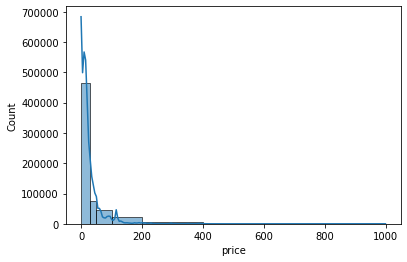

In [87]:
#let's visualize the price
sns.histplot(df.price,bins=[0,30,50,100,200,400,999],kde=True)
plt.show()

In [88]:
#replace zeros with the median
df['price'] = df['price'].replace(0,df['price'].median())

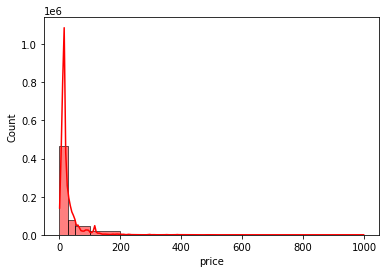

In [89]:
#let's visualize the price after medin imputation
sns.histplot(df.price,bins=[0,30,50,100,200,400,999],color="r",kde=True)
plt.show()

In [90]:
#drop duplicate titles
title_cat = df.drop_duplicates(subset=['title'])
title = title_cat['title']

In [91]:
len(title)

29987

In [92]:
df.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes',
       'overall', 'vote', 'verified', 'reviewTime', 'reviewerID',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime'],
      dtype='object')

In [93]:
item_info = df[['title','reviewText','overall','vote','price']]

In [94]:
item_info.head()

,title,reviewText,overall,vote,price
0,Tupperware Freezer Square Round Container Set ...,I like these containers so much i have ordered...,5,0.0,15.0
1,2 X Tupperware Pure &amp; Fresh Unique Covered...,Hard to open and close.,3,0.0,3.0
2,The Cigar - Moments of Pleasure,Definitely 5 stars. I like everything about t...,5,0.0,150.0
3,The Cigar - Moments of Pleasure,"great quality book. big, heavy duty paper, qua...",5,0.0,150.0
4,The Cigar - Moments of Pleasure,Best book ever written...,5,0.0,150.0


In [95]:
item_info.drop_duplicates(subset=['title'],inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
len(item_info)

29987

In [97]:
#item_info.reset_index(inplace=True)

In [98]:
print(len(item_info))

29987


In [99]:
item_info.columns

Index(['title', 'reviewText', 'overall', 'vote', 'price'], dtype='object')

In [100]:
#combine two columns but to combine multiple column use add(dataframe.iloc[:, 0:10])
#item_info["text"] = item_info["title"] + item_info["reviewText"]

In [101]:
#to confirm
item_info.reset_index(inplace=True)

In [102]:
item_info.head()

,index,title,reviewText,overall,vote,price
0,0,Tupperware Freezer Square Round Container Set ...,I like these containers so much i have ordered...,5,0.0,15.0
1,1,2 X Tupperware Pure &amp; Fresh Unique Covered...,Hard to open and close.,3,0.0,3.0
2,2,The Cigar - Moments of Pleasure,Definitely 5 stars. I like everything about t...,5,0.0,150.0
3,9,Caraselle 2X 50G Appliance Descalene,Did not completely descale my dishwasher,2,0.0,3.0
4,11,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,"Nice chrome, worked very well",5,0.0,3.0


In [103]:
#convert words into their stem and remove stopwords
s = PorterStemmer()
w_corpus = []
for i in range(0, len(item_info)):
    text = re.sub('[^a-zA-Z]', ' ', item_info['title'][i])#get only alphabets
    text = text.lower()
    text = text.split()
    
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    w_corpus.append(text)

In [104]:
w_corpus[0]

'tupperwar freezer squar round contain set'

In [38]:
#one hot encoding to get the index of the words
voc_size=6000
onehot_=[one_hot(words,voc_size)for words in w_corpus] 
print(onehot_[0])

[5065, 5405, 4894, 2062, 3651, 1384]


In [39]:
#add padding to the begining 
docs_emb=pad_sequences(onehot_,padding='pre',maxlen=500)
print(docs_emb[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [40]:
#use sequential model for the embedding
model=Sequential()
model.add(Embedding(voc_size,10,input_length=500))
model.compile('adam','mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 10)           60000     
Total params: 60,000
Trainable params: 60,000
Non-trainable params: 0
_________________________________________________________________


In [41]:
#get the word matrix
word_matrix = model.predict(docs_emb)

In [42]:
word_matrix[0]

array([[ 0.00869353, -0.01880107, -0.02606757, ...,  0.04977207,
         0.03185859,  0.00331436],
       [ 0.00869353, -0.01880107, -0.02606757, ...,  0.04977207,
         0.03185859,  0.00331436],
       [ 0.00869353, -0.01880107, -0.02606757, ...,  0.04977207,
         0.03185859,  0.00331436],
       ...,
       [ 0.01980474, -0.03535252,  0.02838237, ...,  0.02819699,
        -0.00431286, -0.03478814],
       [-0.03222167, -0.02019463,  0.03478313, ..., -0.01364093,
         0.01354848,  0.01069329],
       [ 0.017351  , -0.0279273 , -0.04542051, ..., -0.00110254,
         0.0474368 ,  0.00580219]], dtype=float32)

In [43]:
item_info.head(0)

,index,title,reviewText,overall,vote,price


In [44]:
##drop columns with text
item_info.drop(columns=['index','title','reviewText'],inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [45]:
item_info.columns

Index(['overall', 'vote', 'price'], dtype='object')

In [53]:
#apply scaling on the numerical data
scaler = StandardScaler()
scaler.fit(item_info)

result = scaler.transform(item_info)

In [47]:
result[0]

array([ 0.62826186, -0.14675415, -0.40044361])

In [57]:
#add the title vectors to the table
vec_df = item_info.assign(title=[*word_matrix])

In [58]:
#convert the scaled numerical data into dataframe
num_df = pd.DataFrame(result, columns=['Rating', 'Vote','Price'])

In [59]:
#join both
train = pd.concat([vec_df, num_df], axis=1, join='inner')

In [66]:
#drop redundant columns
train.drop(columns=['overall','vote','price'],axis=1,inplace=True)

In [67]:
train.head()

,title,Rating,Vote,Price
0,"[[0.008693527, -0.018801069, -0.026067568, 0.0...",0.628262,-0.146754,-0.400444
1,"[[0.008693527, -0.018801069, -0.026067568, 0.0...",-0.749916,-0.146754,-0.599031
2,"[[0.008693527, -0.018801069, -0.026067568, 0.0...",0.628262,-0.146754,1.833659
3,"[[0.008693527, -0.018801069, -0.026067568, 0.0...",-1.439005,-0.146754,-0.599031
4,"[[0.008693527, -0.018801069, -0.026067568, 0.0...",0.628262,-0.146754,-0.599031
